In [7]:
# Bunch of useful libraries + wngrad
from collections import defaultdict
import numpy as np
import numpy.matlib
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
import helpers
%matplotlib inline

# SVM parameters

In [8]:
DATA_TRAIN_PATH = '../labs/ex09/template/data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


In [9]:
# w_t = np.zeros(300)
# w_t_close = np.random.normal(0, 1, size = w_t.shape)
# # w_t_close = w_t - 10

# batch_size = 20
# i = np.random.randint(A.shape[0] - batch_size)
# lambda_ = 0.01
# num_data_points = A.shape[0]
# A_batch, y_batch = np.copy(A[i:i+batch_size, :]), np.copy(y[i:i+batch_size]) 


# gradient = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t, num_data_points)
# gradient_close = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t_close, num_data_points)
 
# initial_b = np.linalg.norm(gradient - gradient_close)/np.linalg.norm(w_t - w_t_close)
# print(initial_b)
# print(helpers.calculate_accuracy(y, A, w_t))
# z = A.dot(w_t_wngrad) * y
# plt.figure(figsize = (20, 8))
# plt.ylim([0, 400])
# plt.plot(gradient)
# plt.plot(gradient_close, )
# plt.plot(z)
# plt.plot(y)
# plt.plot(w_t)
# plt.plot(w_t_close)

In [4]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 100000
    lambda_ = 0.01
    
    
    w_t = np.zeros(num_features)
    
    for current_iter in range(max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = helpers.compute_gradient_svm(np.array([A_batch]), np.array([b_batch]), lambda_, w_t, num_data_points)
        # Update rule for SGD SVM
        w_t = w_t - gamma * gradient
        
        if current_iter % 10000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            print(f'iteration={current_iter}, primal:{primal_value:.5f}, gradient_shape = {gradient.shape}, gradient_mean/std = {gradient.mean():.2f}, {gradient.std():.2f}, wt_mean = {w_t.mean():.2f}, {w_t.std():.2f}')
        if current_iter % 100 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w_t)))
    return history, w_t


def wn_grad_svm_demo(A, y, C=1, trace=False, batch_size = None, b_sq = False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 100000
    lambda_ = 0.01
    if batch_size == None:
        A_batch, y_batch = np.copy(A), np.copy(y)
    
    
    # Initiliaze weights w_t
    w_t = np.zeros(num_features)
    
    
    # Iterate
    for current_iter in range(max_iter):
        if batch_size != None:
            i = random.randint(0,num_data_points - batch_size)
            A_batch, y_batch = np.copy(A[i:i+batch_size, :]), np.copy(y[i:i+batch_size]) 
        else:
            A_batch, y_batch = np.copy(A), np.copy(y)
        
        ####### Compute gradient
        gradient = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t, num_data_points)
        
        # If necessary, initialize b param
        if current_iter == 0:
            # If necessary, b parameter initialization
            if C == None:
                initial_b = 0
                for i in np.arange(-3, 3, 0.2):                    
                    w_t_close = np.random.normal(w_t.mean(), np.array([10], dtype = float)**i, size = w_t.shape)
                    gradient_temp = helpers.compute_gradient_svm(A, y, lambda_, w_t, num_data_points)
                    gradient_close = helpers.compute_gradient_svm(A, y, lambda_, w_t_close, num_data_points)
                    b = np.linalg.norm(gradient_temp - gradient_close)/np.linalg.norm(w_t - w_t_close)
                    if b > initial_b:
                        initial_b = b
                b = initial_b
                print('initial b:', initial_b, np.linalg.norm(gradient))
            else:
                # If C was specified, initialization will be in terms of the gradient norm
                b = C*np.linalg.norm(gradient)
        
        # Update params
        w_t = w_t - gradient/b
        
        # Compute gradient again with updated params
#         gradient = helpers.compute_gradient_svm(A_batch, y_batch, lambda_, w_t, num_data_points)
        # Update b
        if b_sq:
            b = b + (np.linalg.norm(gradient)**2)/b
        else:
            b = b + (np.linalg.norm(gradient))/b
        
#         w_t = w_t - gradient*0.0001
        
        if current_iter % 10000 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            print(f'iteration={current_iter}, primal:{primal_value:.5f}, b = {b}, gradient_shape = {gradient.shape}, gradient_mean/std = {gradient.mean():.2f}, {gradient.std():.2f}, \
wt_shape = {w_t.shape}, wt_mean = {w_t.mean():.2f}, {w_t.std():.2f}')
        if current_iter % 100 == 0:
            primal_value = helpers.calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
                history['gradient_norm'].append(np.linalg.norm(gradient))
                history['b'].append(b)
    print("training accuracy = {l}".format(l=helpers.calculate_accuracy(y, A, w_t)))
    return history, w_t

In [10]:
history_wngrad, w_t_wngrad = wn_grad_svm_demo(A, y, C=None, trace=True, batch_size = 30)
history_wngrad_b2, w_t_wngrad = wn_grad_svm_demo(A, y, C=None, trace=True, batch_size = 30, b_sq = True)

initial b: 299.01168812274534 3682.325228710794
iteration=0, primal:1054.68784, b = 311.32667571346184, gradient_shape = (300,), gradient_mean/std = 87.80, 193.62, wt_shape = (300,), wt_mean = -0.29, 0.65
iteration=10000, primal:241.62458, b = 1224.203038988896, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.15, 1.67
iteration=20000, primal:235.66615, b = 1574.0835472926422, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.13, 1.81
iteration=30000, primal:234.01267, b = 1847.1870861681955, gradient_shape = (300,), gradient_mean/std = 0.82, 14.28, wt_shape = (300,), wt_mean = -0.11, 1.90
iteration=40000, primal:232.35787, b = 2055.1747349784996, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.10, 1.96
iteration=50000, primal:231.38703, b = 2236.0684736505577, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_shape = (300,), wt_mean = -0.09, 1.99
iterat

In [14]:
history_sgd_4, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-4, batch_size=500, trace=True)
history_sgd_3, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 1e-3, batch_size=500, trace=True)
# history_sgd_35, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 5e-4, batch_size=500, trace=True)
# history_sgd_35, wt_sgd = stochastic_gradient_descent_svm_demo(A, y, 5e-5, batch_size=500, trace=True)


iteration=0, primal:1631.03941, gradient_shape = (300,), gradient_mean/std = 132.11, 556.58, wt_mean = -0.01, 0.06
iteration=10000, primal:301.13574, gradient_shape = (300,), gradient_mean/std = -0.00, 0.01, wt_mean = -0.08, 0.87
iteration=20000, primal:277.64306, gradient_shape = (300,), gradient_mean/std = -0.00, 0.01, wt_mean = -0.07, 1.08
iteration=30000, primal:267.63959, gradient_shape = (300,), gradient_mean/std = -0.00, 0.01, wt_mean = -0.07, 1.19
iteration=40000, primal:262.91367, gradient_shape = (300,), gradient_mean/std = -0.00, 0.01, wt_mean = -0.08, 1.29
iteration=50000, primal:260.22069, gradient_shape = (300,), gradient_mean/std = -0.00, 0.01, wt_mean = -0.06, 1.39
iteration=60000, primal:256.13852, gradient_shape = (300,), gradient_mean/std = -0.00, 0.01, wt_mean = -0.05, 1.47
iteration=70000, primal:254.28156, gradient_shape = (300,), gradient_mean/std = -0.00, 0.02, wt_mean = -0.04, 1.53
iteration=80000, primal:260.19739, gradient_shape = (300,), gradient_mean/std = 

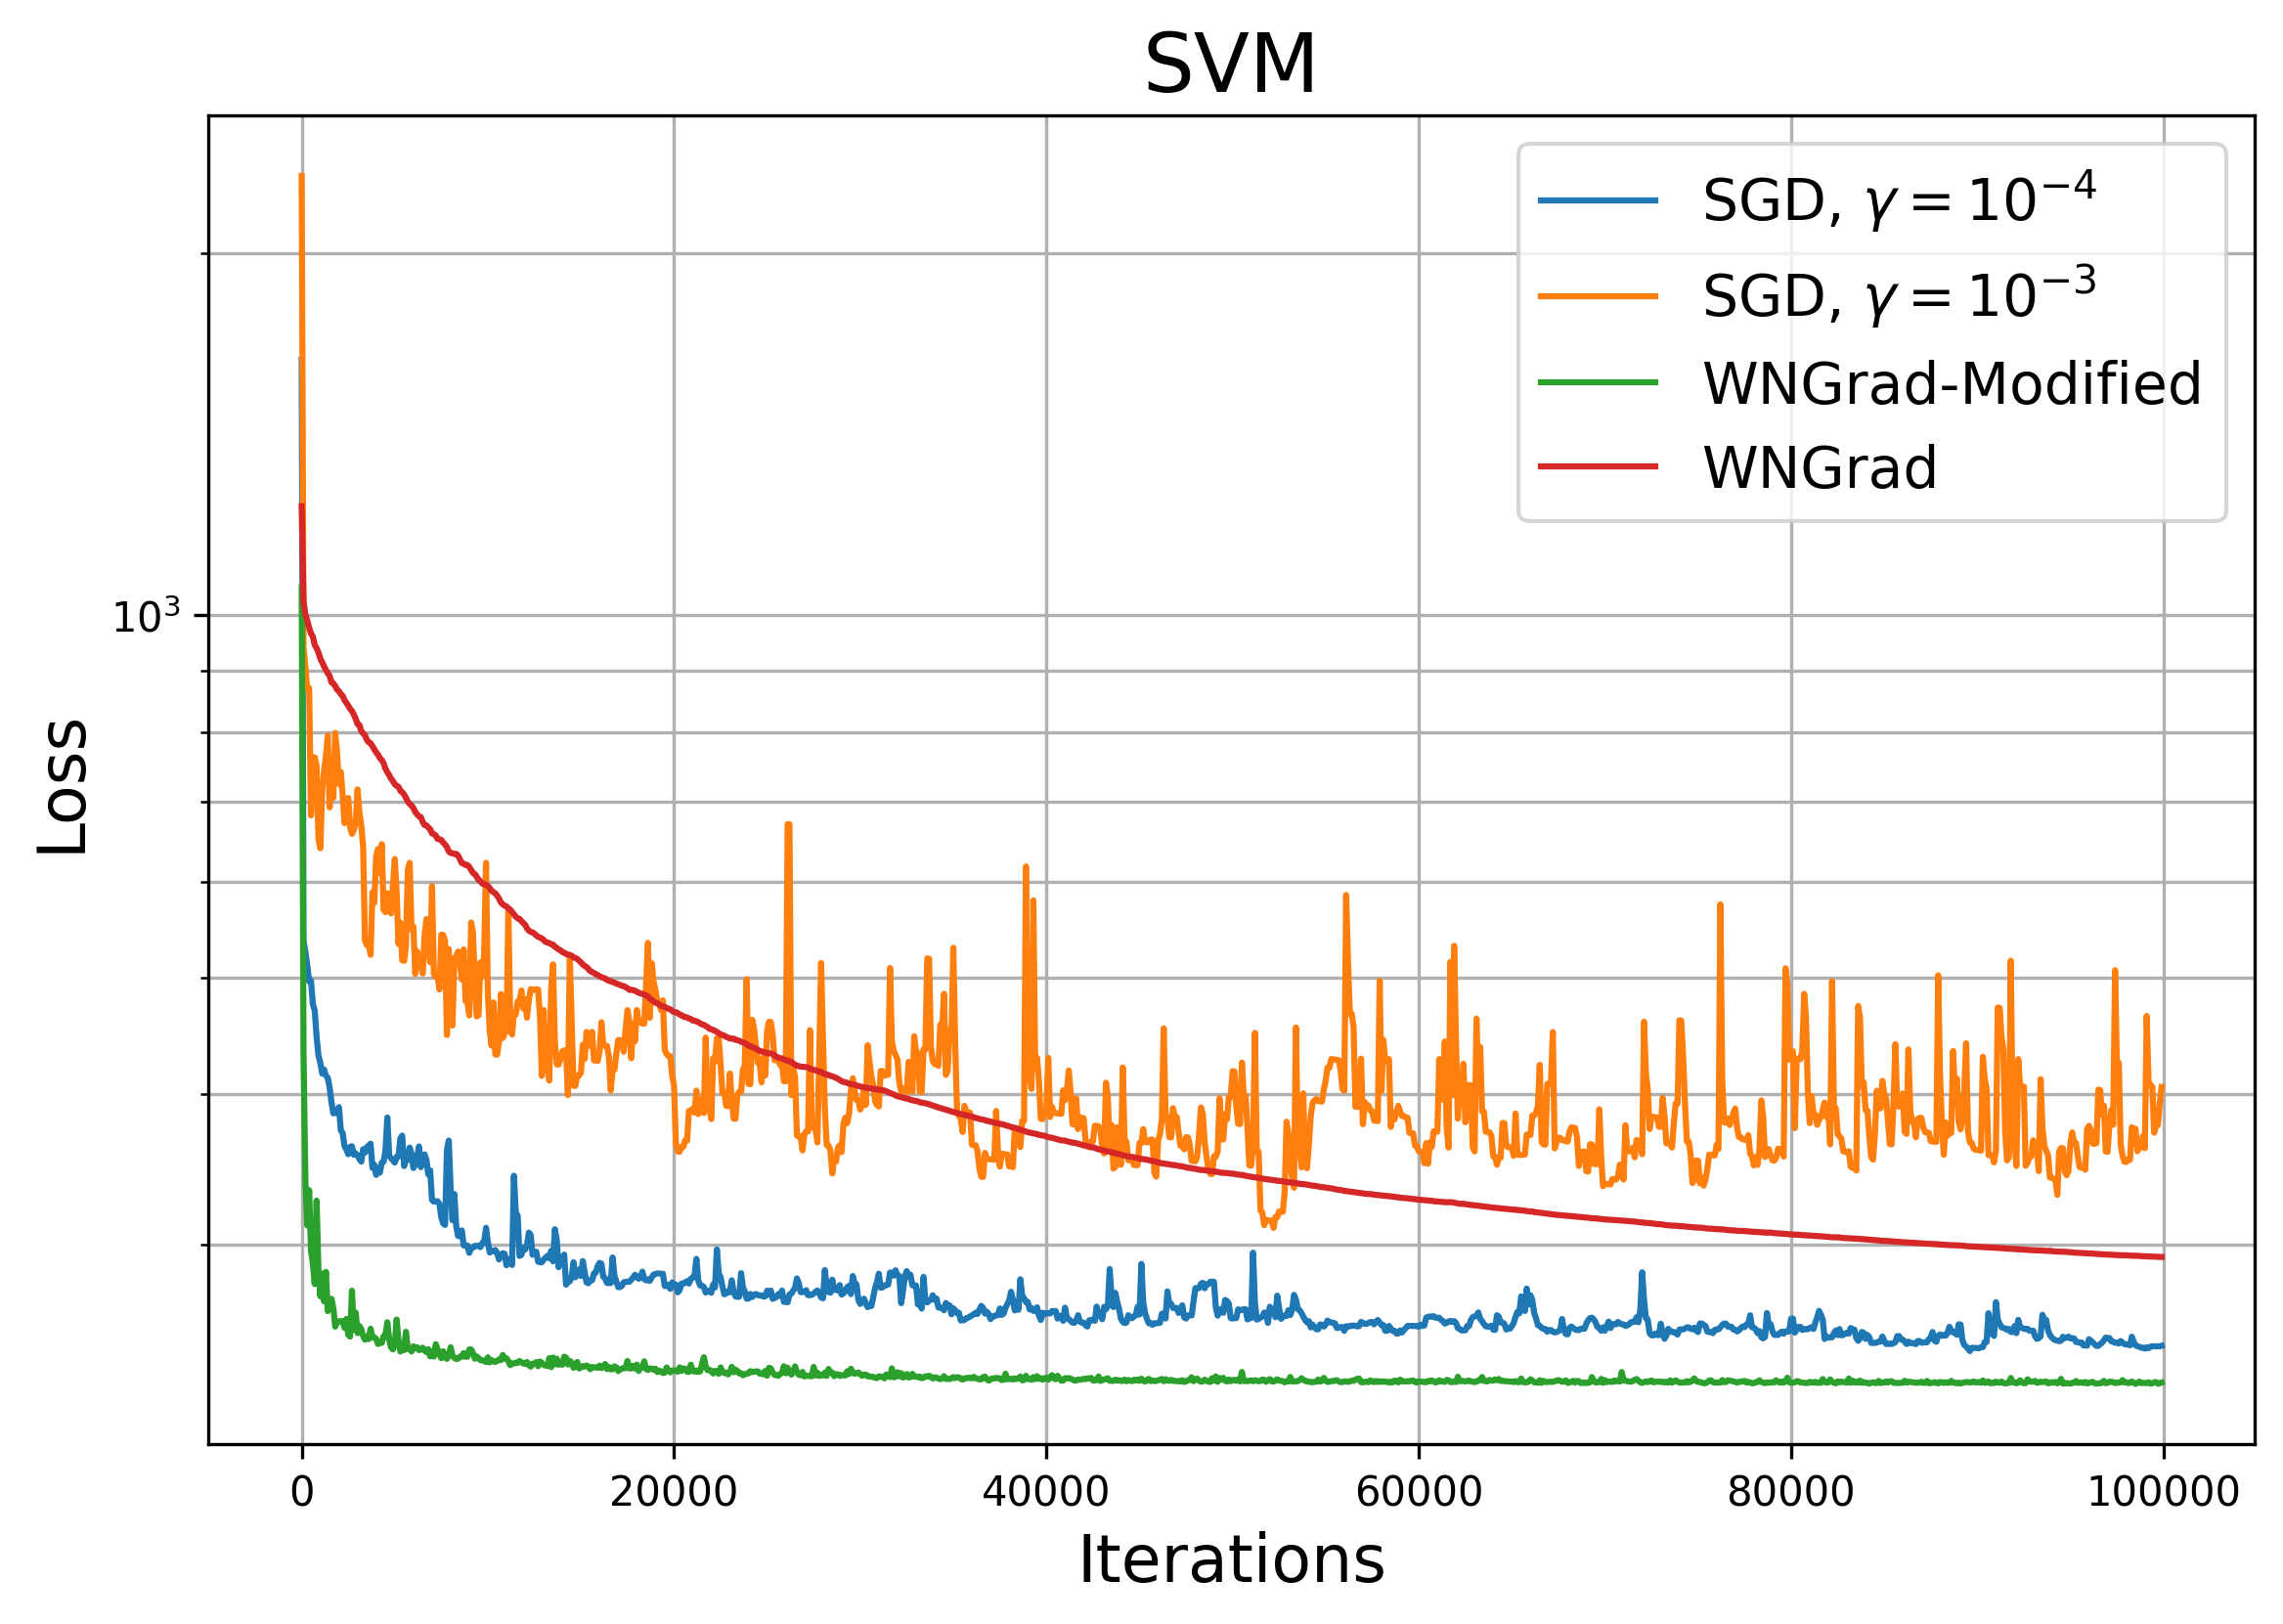

In [15]:
plt.figure(figsize = (9, 6))
fig = plt.gcf()
ax = plt.gca()
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="SGD, $\gamma = 10^{-4}$")
plt.semilogy(history_sgd_3["iter"], history_sgd_3["objective_function"], label="SGD, $\gamma = 10^{-3}$")
plt.semilogy(history_wngrad["iter"], history_wngrad["objective_function"], label="WNGrad-Modified")
plt.semilogy(history_wngrad_b2["iter"], history_wngrad_b2["objective_function"], label="WNGrad")
plt.grid(which = 'minor')
plt.grid(which = 'major')
plt.ylabel('Loss', fontsize = 16)
plt.xlabel('Iterations', fontsize = 16)
plt.gcf().set_dpi(300)
plt.legend(prop={'size': 14})
plt.title('SVM', fontsize = 20)
plt.show()
fig.savefig('SVM')

In [13]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'